[Оригинальный файл на Kaggle](https://www.kaggle.com/code/sharthz23/metrics-validation-strategies-and-baselines)

# Расчёт метрик

In [70]:
import os
from collections import defaultdict

from more_itertools import pairwise
import pandas as pd
from matplotlib import pyplot as plt

In [71]:
plt.style.use("ggplot")

In [72]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import precision_at_k, join_true_pred_and_preprocess, recall_at_k, mean_reciprocal_rank, mean_average_prec
from recs_utils.load_data import load_users, load_items, load_interactions, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge
from recs_utils.split import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
data_dir = "data"

In [74]:
df = load_interactions(os.path.join(data_dir, "interactions.csv"))
df_users = load_users(os.path.join(data_dir, "users.csv"))
df_items = load_items(os.path.join(data_dir, "items.csv"))

In [75]:
df["rating"].unique()

[nan, 5.0, 4.0, 2.0, 3.0, 1.0]
Fill: nan
IntIndex
Indices: array([1, 2, 3, 4, 5], dtype=int32)

In [76]:
sample_true, sample_rec = sample_true_rec_data()

In [77]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [78]:
joined_data

rank  item_count_per_user
user_id item_id                                                       
Аня     Мастер и Маргарита                    NaN                    1
Боря    451° по Фаренгейту                    1.0                    1
Вася    Зеленая миля                          3.0                    2
        Рита Хейуорт и спасение из Шоушенка   NaN                    2

In [79]:
precision_at_k(joined_data, k=2)

0.16666666666666666

In [80]:
joined_data

rank  item_count_per_user  hit@2   
user_id item_id                                                                 
Аня     Мастер и Маргарита                    NaN                    1  False  \
Боря    451° по Фаренгейту                    1.0                    1   True   
Вася    Зеленая миля                          3.0                    2  False   
        Рита Хейуорт и спасение из Шоушенка   NaN                    2  False   

                                             hit@2/2  
user_id item_id                                       
Аня     Мастер и Маргарита                       0.0  
Боря    451° по Фаренгейту                       0.5  
Вася    Зеленая миля                             0.0  
        Рита Хейуорт и спасение из Шоушенка      0.0

In [81]:
recall_at_k(joined_data, 1)

0.3333333333333333

In [82]:
mean_reciprocal_rank(joined_data)

0.4444444444444444

In [83]:
mean_average_prec(joined_data)

0.3888888888888889

In [84]:
test_dates = df['start_date'].unique()[-7:]
test_dates = list(pairwise(test_dates))

In [85]:
def validate(interactions, user_features, test_dates, model_cls):
    metrics = defaultdict(list)

    for i, split_pair in enumerate(test_dates):
        train, test = train_test_split(interactions, split_pair)
        baseline = model_cls()
        baseline.fit(train, user_features)
        
        predicted_recs = baseline.predict(
            pd.merge(
                pd.Series(index=test.index.unique("user_id"), name="a"), 
                user_features, 
                how="left", 
                left_index=True, 
                right_index=True
            )
        )

        assert predicted_recs.index.unique("user_id").nunique() == test.index.unique("user_id").nunique()

        estimated = join_true_pred_and_preprocess(test, predicted_recs)
        metrics["mrr"].append(mean_reciprocal_rank(estimated))
        metrics["mean_avg_prec"].append(mean_average_prec(estimated))
        metrics["fold"].append(i)

    return pd.DataFrame(metrics)

In [86]:
metrics = validate(df, df_users, test_dates, PopularRecommender)

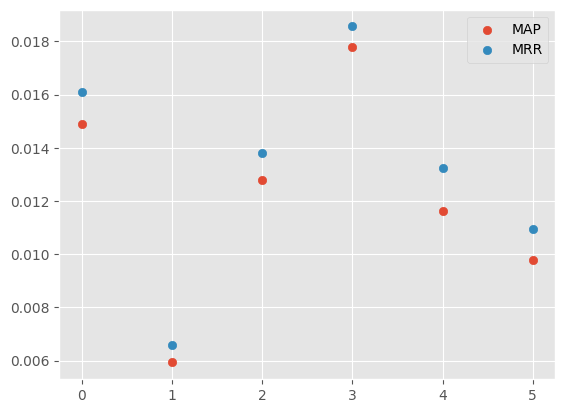

In [87]:
plt.scatter(data=metrics, x="fold", y="mean_avg_prec", label="MAP")
plt.scatter(data=metrics, x="fold", y="mrr", label="MRR")
plt.legend()

In [88]:
metrics = validate(df, df_users, test_dates, PopularRecommenderPerAge)

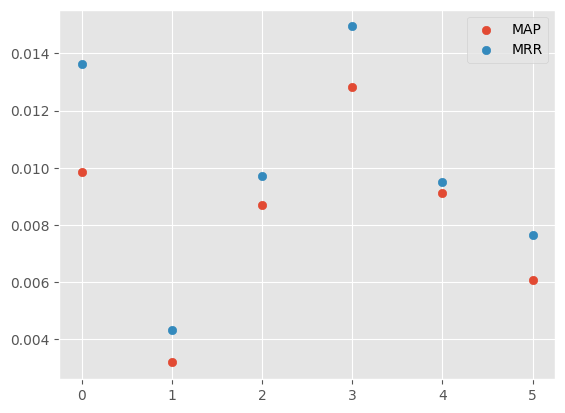

In [89]:
plt.scatter(data=metrics, x="fold", y="mean_avg_prec", label="MAP")
plt.scatter(data=metrics, x="fold", y="mrr", label="MRR")
plt.legend()